In [1]:
using Images , PyPlot
using LinearAlgebra , Statistics , StatsBase

## Take information (RGB , xy) of a picture as 5-dimensional data set 

In [2]:
function get_Z(img)
    width , length = size(img) ;
    n = width*length ;
    # ColorNorm = zeros(n) ;
    # PixelNorm  = zeros(n) ;
    
    Z = zeros(n , 5) ;
    t = 1 ;
    for ii = 1 : width
        for jj = 1 : length
            # RGB
            Z[t,1] = img[ii,jj].r  ;
            Z[t,2] = img[ii,jj].g ;
            Z[t,3] = img[ii,jj].b ;
            
            # xy
            Z[t,4] = ii ;
            Z[t,5] = jj ;
            
            # ColorNorm[t] = Z[t,1]^2 + Z[t,2]^2 + Z[t,3]^2 ;
            # PixelNorm[t]  = Z[t,4]^2 + Z[t,5]^2 ;
            t += 1 ;
        end
    end
    
    # normalize the range of 5 dimension to [0 , 1]
    for ii = 1 : 5
        min  = minimum(Z[: , ii]) ;
        max = maximum(Z[: , ii]) ;
        
        Z[: , ii] = (Z[: , ii] .- min) ./ (max - min) ;
    end
    
    #Z[: , 1:3] .*= sqrt(median(PixelNorm) / median(ColorNorm)) ;
    
    return Z ;
    
end

get_Z (generic function with 1 method)

## Randomly pick some data for diffusion maps

In [3]:
function partition(Z , L)
    # Randomly pick L points from Z
    idx = sort(sample(1:size(Z , 1) , L , replace = false)) ;
    
    X = Z[idx , :] ;
    
    return X , idx ;
end

partition (generic function with 1 method)

## Diffusion maps

In [4]:
function DiffMap(X , c = 3 , sigma = 7)
    # get_K
    n = size(X,1) ;
    K = zeros(n,n) ;
    for ii = 1 : n
        for jj = ii+1 : n
            K[ii,jj] = sum((X[ii,:] - X[jj,:]).^2) ;
            K[jj,ii] = K[ii,jj] ;
        end
    end
    
    # local scaling
    # sigma : choose the 7th nearest point as scale for each points
    temp = sort(K , dims = 2 , alg = QuickSort) ;
    temp = temp[: , sigma] ;
    K = exp.(-K ./(sqrt.(temp*transpose(temp)))) ;
    
    # single scaling
    #m = Int(round(0.1 * n)) ; 
    #temp = sort(K , dims = 2 , alg = QuickSort) ;
    #temp = mean(temp[: , 1:m] , dims = 2) ;
    #sigma = median(temp) ;
    #K = exp.(-K ./ sigma) ;
    
    # get_Ppron
    Dsqinv = 1 ./ sqrt.(sum(K , dims = 2)) ;
    K = K .* Dsqinv .* transpose(Dsqinv) ;
    
    # get_eig
    S , K = eigen(K) ; # S is eigenvalue and K is eigenvector
    print("the imag of eigenvalue : " , maximum(abs.(imag(S)))) ;
    S = real(S) ;
    p = partialsortperm(S , 2 : c+1 , rev = true) ;
    S = S[p] ;
    K = K[: , p] ;
    print(" ,the imag of eigenvector : " , maximum(abs.(imag(K))) , "\n") ;
    K = real(K) ;
    
    return K .* Dsqinv .* transpose(S) ;
end

DiffMap (generic function with 3 methods)

## K-means clustering

In [5]:
function k_means_sample(Y , index)
    # The function is used to disperse several centers in data space appropriately
    n = size(Y , 1) ;
    m = size(index , 1) ;
    D = zeros(n) ; # the distance between the point and the nearest center
    
    # get the distance between the point and the nearest center
    for ii = 1 : n
        D[ii] = sum((Y[ii , :] - Y[index[1] , :]).^2) ;
        
        for jj = 2 : m
            distance = sum((Y[ii , :] - Y[index[jj] , :]).^2) ;
            
            if D[ii] < distance
                D[ii] = distance ;
            end
        end
    end
    
    # get the probability of points that become the next center
    D ./= sum(D) ;
    
    # find next center randomly
    target = rand() ;
    temp = D[1] ;
    idx = 1 ;
    while temp < target
        idx += 1 ;
        temp += D[idx] ;
    end
    
    return [index ; idx] ;
end

k_means_sample (generic function with 1 method)

In [6]:
function k_means(Y , cluster) # cluster is the number of groups
    
    n = size(Y,1) ;
    
    # pick the same number of numbers as cluster from 1~n
    index = rand(1:n , 1) ;
    for ii = 1 : cluster - 1
        index = k_means_sample(Y , index) ;
    end
    
    group1 = classify(Y , Y[index , :]) ; # find the first weight
    center = update_center(Y , group1 , cluster) ;  # update the center
    group2 = classify(Y , center) ;       # find the next weight
    
    # classify and update repeatly until the weight becomes stabilize.
    time = 1 ;
    while  group1 !=  group2
        # replace as previous one
        group1 = group2 ;
        
        # update and classify to get a new groups
        center  = update_center(Y , group1 , cluster) ;
        group2 = classify(Y , center) ;
        
        time += 1 ;
    end
    
    print("The update times = ", time) ; # print the number of executions of while loop.
    
    return group1 , center ;
end

k_means (generic function with 1 method)

In [7]:
function classify(Y , center)
    
    n = size(Y,1) ;
    cluster = size(center,1) ; # number of center
    weight = 0 ;
    group = Array{Int8 , 1}(undef , n) ; # Classify the n points by label as 1 ~ cluster.
    distance = zeros(cluster) ;
    
    for ii = 1 : n
        
        # For all points in Y , find the minimum of distances with centers.
        DistanceMin = sum((Y[ii,:] - center[1,:]).^2) ;
        group[ii] = 1 ;
        for jj = 2 : cluster
            
            # Strictly speaking , it is the square of the distance
            distance = sum((Y[ii,:] - center[jj,:]).^2) ;
            
            # If the point is closer to one center than the others,
            # then it will be put in the group belong to the center.
            if DistanceMin > distance
                DistanceMin = distance ;
                group[ii] = jj ;
            end
        end
    end
    
    return group ;
end

classify (generic function with 1 method)

In [8]:
function update_center(Y , group , cluster)
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    num = zeros(cluster) ;
    
    # find new centroids (or geometric center) from each group.
    for ii = 1 : n
        center[group[ii] , :] += Y[ii,:] ;
        num[group[ii]] += 1 ;
    end
    
    center ./= num ;
    
    return center ;
end

update_center (generic function with 1 method)

## k-nearest neighbor

In [9]:
function kNN(Z , X , group , k)
    n , d = size(Z) ;
    L = size(X , 1) ;
    cluster = maximum(group) ;
    Zgroup = Array{Int8 , 1}(undef , n) ;
    
    for ii = 1 : n
        # For one point in Z , get the distance between X
        temp = zeros(L) ;
        for jj = 1 : L
            temp[jj] = sum( (Z[ii , :] - X[jj , :]).^2 ) ;
        end
        
        # take indeces of k-nearest neighbors
        idx = partialsortperm(temp , 1 : k) ;
        
        # get the number for every group in these k neighbors
        temp = zeros(cluster) ;
        for jj = 1 : k
            temp[group[idx[jj]]] += 1 ;
        end
        
        # find the group which has the most number
        pos = 1 ;
        for jj = 2 : cluster
            if temp[pos] < temp[jj]
                pos = jj ;
            end
        end
        Zgroup[ii] = pos ;
        
    end
    
    return Zgroup ;
end

kNN (generic function with 1 method)

## Color Dictionary

In [10]:
function Draw(Y , color)
    n = size(Y , 1) ;
    d = size(Y , 2) ;
    
    if d > 2
        scatter3D(Y[:,1] , Y[:,2] , Y[:,3] , s = 3 , c = color) ;    
    elseif d > 1
        scatter(Y[:,1] , Y[:,2] , s = 3 , c = color) ;
    else
        scatter(1:n , Y , s = 3 , c = color) ;
    end
end

Draw (generic function with 1 method)

In [11]:
function Color1(group)
    dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;
    
    cc = Array{String}(undef, size(group , 1)) ;
    for ii = 1 : size(group , 1)
        cc[ii] = dict[group[ii]] ;
    end
    
    return cc ;
end

Color1 (generic function with 1 method)

In [12]:
function Color2(group , width , length)
    dict = Dict(1 => RGB(1,0,0) , 2 => RGB(0,1,0) , 3 => RGB(0,0,1) , 4 => RGB(0,0,0) , 5 => RGB(0.5,0.16,0.16) , 6 => RGB(0,1,1) , 7 => RGB(1,0.38,0)) ;
    
    Yimg = Array{RGB{Float64} , 2}(undef , width , length) ;
    t = 1 ;
    for ii = 1 : width
        for jj = 1 : length
            Yimg[ii,jj] = dict[Zgroup[t]] ;
            t += 1 ;
        end
    end
    
    return Yimg ;
end

Color2 (generic function with 1 method)

## Implementation

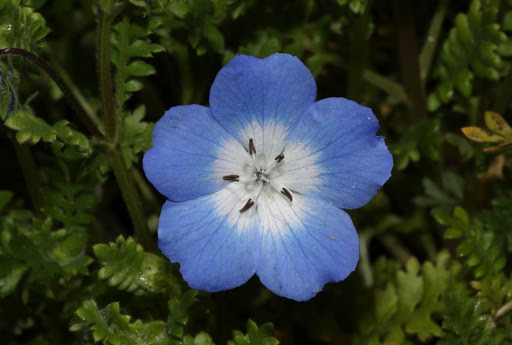

In [13]:
img = load("test1.jpg") 

In [14]:
L = 1000 ;
cluster = 7 ;

Z = get_Z(img) ;
X , ~ = partition(Z , L) ;
Y = DiffMap(X , 3) ;

the imag of eigenvalue : 0.0 ,the imag of eigenvector : 0.0


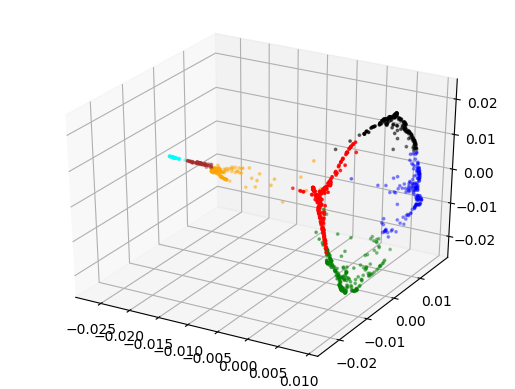

The update times = 6

In [15]:
group , ~ = k_means(Y , cluster) ;
cc = Color1(group) ;

Draw(Y , cc) ;

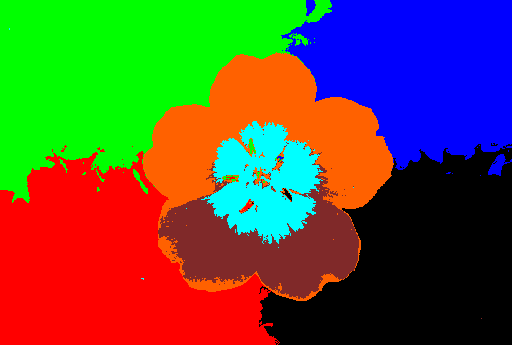

In [16]:
Zgroup = kNN(Z , X , group , 11) ;
Yimg = Color2(Zgroup , size(img,1) , size(img,2))

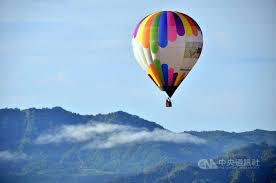

In [42]:
img = load("test2.jpg")

In [43]:
L = 1000 ;
cluster = 7 ;

Z = get_Z(img) ;
X , ~ = partition(Z , L) ;
Y = DiffMap(X , 3) ;

the imag of eigenvalue : 0.0 ,the imag of eigenvector : 0.0


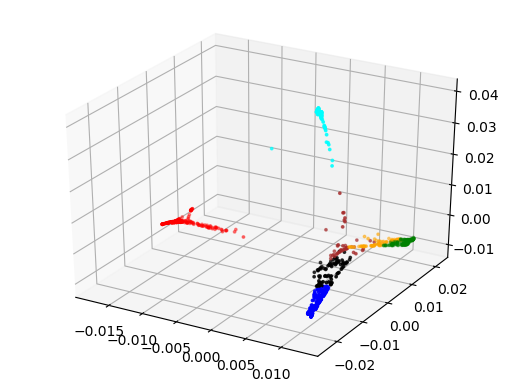

The update times = 24

In [44]:
group , ~ = k_means(Y , cluster) ;
cc = Color1(group) ;

Draw(Y , cc) ;

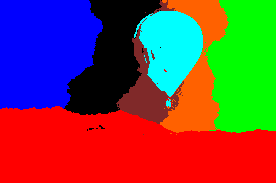

In [45]:
Zgroup = kNN(Z , X , group , 11) ;
Yimg = Color2(Zgroup , size(img,1) , size(img,2))

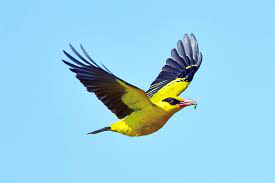

In [46]:
img = load("test3.jpg")

In [47]:
L = 1000 ;
cluster = 7 ;

Z = get_Z(img) ;
X , ~ = partition(Z , L) ;
Y = DiffMap(X , 3) ;

the imag of eigenvalue : 0.0 ,the imag of eigenvector : 0.0


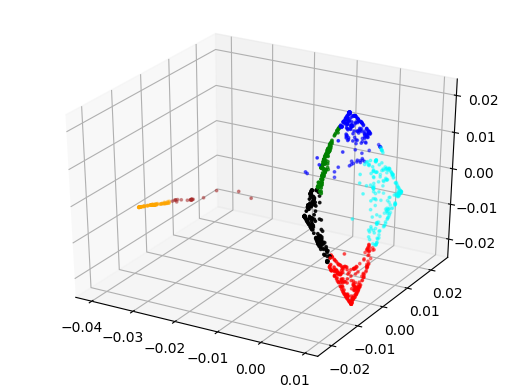

The update times = 8

In [48]:
group , ~ = k_means(Y , cluster) ;
cc = Color1(group) ;

Draw(Y , cc) ;

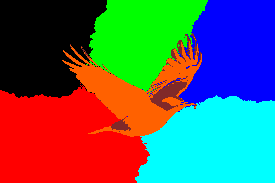

In [49]:
Zgroup = kNN(Z , X , group , 11) ;
Yimg = Color2(Zgroup , size(img,1) , size(img,2))